# 自然语言处理

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self):
        self.char2index = { '^': SOS_token, '$': EOS_token }
        self.index2char = { SOS_token: '^', EOS_token: '$' }
    
    def get_char2index(self, c, wild_char=None):
        if c in self.char2index: return self.char2index[c]
        if wild_char is not None: return self.char2index[wild_char]
        idx = len(self.char2index)
        self.char2index[c] = idx
        self.index2char[idx] = c
        return idx
    
    def get_word2tensor(self, word, wild_char=None):
        word = word.lower()
        indexes = [self.get_char2index(c, wild_char) for c in word]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

lang_en = Lang()
lang_cn = Lang()
lang_en.get_word2tensor('abcdefghijklmnopqrstuvwxyz \'-')

tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [20],
        [21],
        [22],
        [23],
        [24],
        [25],
        [26],
        [27],
        [28],
        [29],
        [30],
        [ 1]])

In [2]:
class Dataset:
    def __init__(self):
        super().__init__()
        self.data = []
    
    def load(self, file_path):
        with open(file_path, 'r', encoding='utf8') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('|')
            if len(items) != 3: continue
            lang_cn.get_word2tensor(items[0])
            lang_en.get_word2tensor(items[1], wild_char=' ')
            self.data.append([items[1], items[0]])

dataset = Dataset()
dataset.load('data/names-dataset.txt')

In [28]:
MAX_LENGTH = 64

import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


print(len(lang_cn.char2index))
print(len(lang_en.char2index))
print(lang_en.char2index)
encoder = EncoderRNN(len(lang_en.char2index), 128)
decoder = AttnDecoderRNN(128, len(lang_cn.char2index))

433
31
{'^': 0, '$': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, ' ': 28, "'": 29, '-': 30}


In [4]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == 1:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [5]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def tensorsFromPair(pair):
    input_tensor = lang_en.get_word2tensor(pair[0], wild_char=' ')
    target_tensor = lang_cn.get_word2tensor(pair[1])
    return (input_tensor, target_tensor)

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(dataset.data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = lang_en.get_word2tensor(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        decoder_hiddens = torch.zeros(max_length, decoder.hidden_size)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            decoder_hiddens[di] = decoder_hidden[0,0]
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang_cn.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1], decoder_hiddens[:di + 1], encoder_outputs[:ei + 1]

In [8]:
def save_model(encoder, decoder, model_path='data/en2cnname.model'):
    checkpt = {
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }
    torch.save(checkpt, model_path)

def load_model(encoder, decoder, model_path='data/en2cnname.model'):
    checkpt = torch.load(model_path)
    encoder.load_state_dict(checkpt['encoder'])
    decoder.load_state_dict(checkpt['decoder'])

load_model(encoder, decoder)
#save_model(encoder, decoder)

In [32]:
test_names = [
    'Richard', 'Andy', 'Johnny', 'Johann', 'Sebastian', 'Bach',
    'Mozart', 'Beethoven', 'Tchaikovsky', 'Brahms', 'Mendelssohn',
    'Dmitri', 'Dmitriyevich', 'Shostakovich',
    'Albert', 'Einstein', 'Issac', 'Newton', 'Sakura', 'Deep Learning'
]

for input in test_names:
    output, _, _, _ = evaluate(encoder, decoder, input)
    print([input, output])

['Richard', ['里', '奇', '德', '<EOS>']]
['Andy', ['安', '迪', '<EOS>']]
['Johnny', ['霍', '尼', '<EOS>']]
['Johann', ['约', '汉', '<EOS>']]
['Sebastian', ['塞', '巴', '斯', '斯', '廷', '<EOS>']]
['Bach', ['巴', '奇', '<EOS>']]
['Mozart', ['莫', '扎', '特', '<EOS>']]
['Beethoven', ['贝', '托', '维', '<EOS>']]
['Tchaikovsky', ['扎', '科', '科', '夫', '斯', '基', '<EOS>']]
['Brahms', ['布', '拉', '姆', '斯', '<EOS>']]
['Mendelssohn', ['蒙', '德', '尔', '森', '欣', '<EOS>']]
['Dmitri', ['德', '米', '特', '<EOS>']]
['Dmitriyevich', ['德', '米', '特', '耶', '耶', '维', '奇', '<EOS>']]
['Shostakovich', ['斯', '塔', '塔', '科', '维', '奇', '<EOS>']]
['Albert', ['阿', '尔', '贝', '特', '<EOS>']]
['Einstein', ['恩', '斯', '斯', '坦', '<EOS>']]
['Issac', ['伊', '萨', '克', '<EOS>']]
['Newton', ['纽', '顿', '<EOS>']]
['Sakura', ['萨', '库', '拉', '<EOS>']]
['Deep Learning', ['迪', '普', '尔', '<EOS>']]


input = Shostakovich
output = 斯 塔 塔 科 维 奇 <EOS>


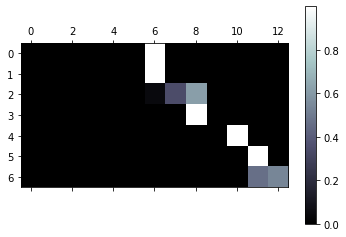

In [33]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    input_len = len(input_sentence) + 1
    fig = plt.figure()
    ax = fig.gca()
    cax = ax.matshow(attentions.numpy()[:,:input_len], cmap='bone')
    fig.colorbar(cax)
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions, hiddens, encoder_outputs = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention('Shostakovich')

2m 5s (- 102m 24s) (10000 2%) 3.6830
4m 3s (- 97m 19s) (20000 4%) 3.0227
5m 59s (- 93m 53s) (30000 6%) 2.5722
7m 56s (- 91m 25s) (40000 8%) 2.3127
9m 54s (- 89m 8s) (50000 10%) 2.1840
11m 50s (- 86m 53s) (60000 12%) 2.1091
13m 47s (- 84m 41s) (70000 14%) 2.0255
15m 43s (- 82m 34s) (80000 16%) 1.9946
17m 40s (- 80m 28s) (90000 18%) 1.9492
19m 36s (- 78m 25s) (100000 20%) 1.9226
21m 31s (- 76m 19s) (110000 22%) 1.8784
23m 28s (- 74m 21s) (120000 24%) 1.8643
25m 25s (- 72m 21s) (130000 26%) 1.8363
27m 22s (- 70m 22s) (140000 28%) 1.8034
29m 16s (- 68m 18s) (150000 30%) 1.7964
31m 11s (- 66m 16s) (160000 32%) 1.7873
33m 5s (- 64m 14s) (170000 34%) 1.7752
34m 59s (- 62m 12s) (180000 36%) 1.7787
36m 54s (- 60m 12s) (190000 38%) 1.7647
38m 48s (- 58m 13s) (200000 40%) 1.7395
40m 43s (- 56m 14s) (210000 42%) 1.7083
42m 38s (- 54m 15s) (220000 44%) 1.7369
44m 33s (- 52m 18s) (230000 46%) 1.7120
46m 29s (- 50m 22s) (240000 48%) 1.6856
48m 24s (- 48m 24s) (250000 50%) 1.6954
50m 20s (- 46m 27s) (

<Figure size 432x288 with 0 Axes>

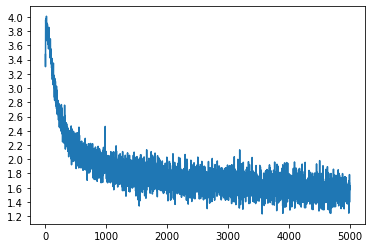

In [29]:
trainIters(encoder, decoder, 500000, print_every=10000)